In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'plates']


In [2]:
data_root = '../input/plates/plates/'
print(os.listdir(data_root))

['train', 'test']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 378.97it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
print(os.listdir('../working/val/cleaned'))

['0013.jpg', '0005.jpg', '0015.jpg', '0008.jpg']


In [6]:
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

img_path="../working/train/cleaned/0002.jpg"
image = Image.open(img_path)
image.show()
# print(image)
image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
# image = Variable(image)
print(image.size())

torch.Size([1, 3, 256, 342])


In [7]:
import torch
import PIL
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

In [1]:
dataset1 = torchvision.datasets.ImageFolder('val',transform=transforms)
show_dataset(dataset1);

NameError: name 'torchvision' is not defined

In [9]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
#         iaa.Sometimes(0.25,
#                       iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
#                                  iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('val', transform=transforms)

In [2]:
show_dataset(dataset);

NameError: name 'show_dataset' is not defined

In [11]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
#ImgAugTransform(),lambda x: PIL.Image.fromarray(x),
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [12]:
print(len(train_dataloader), len(train_dataset))

4 32


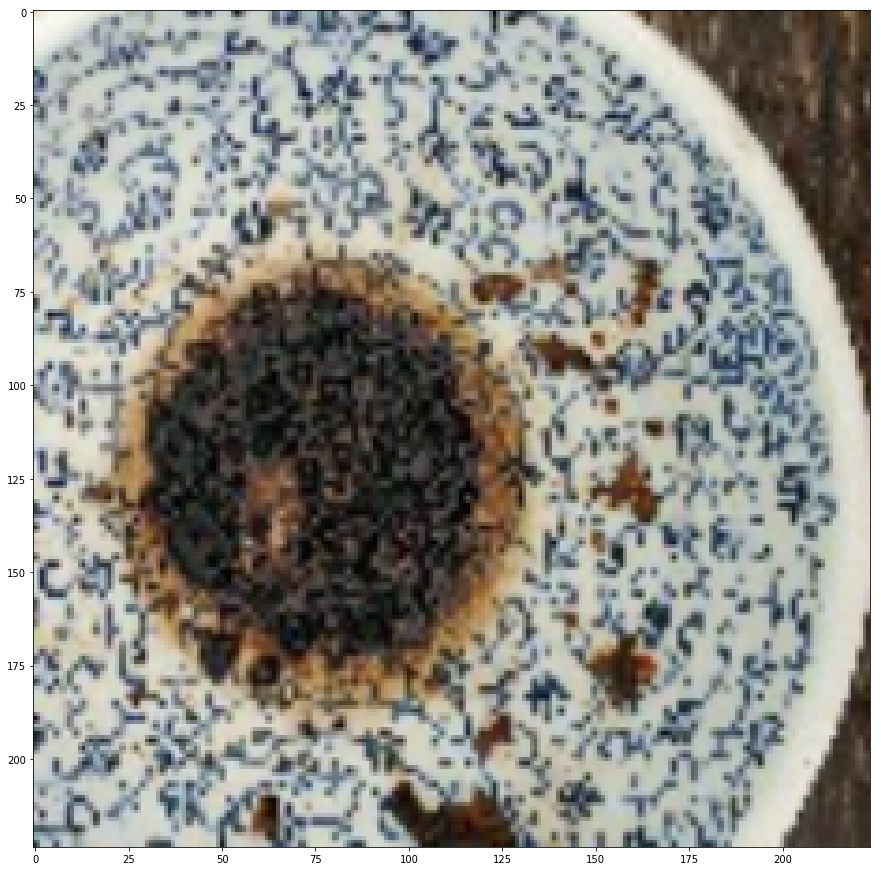

In [13]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

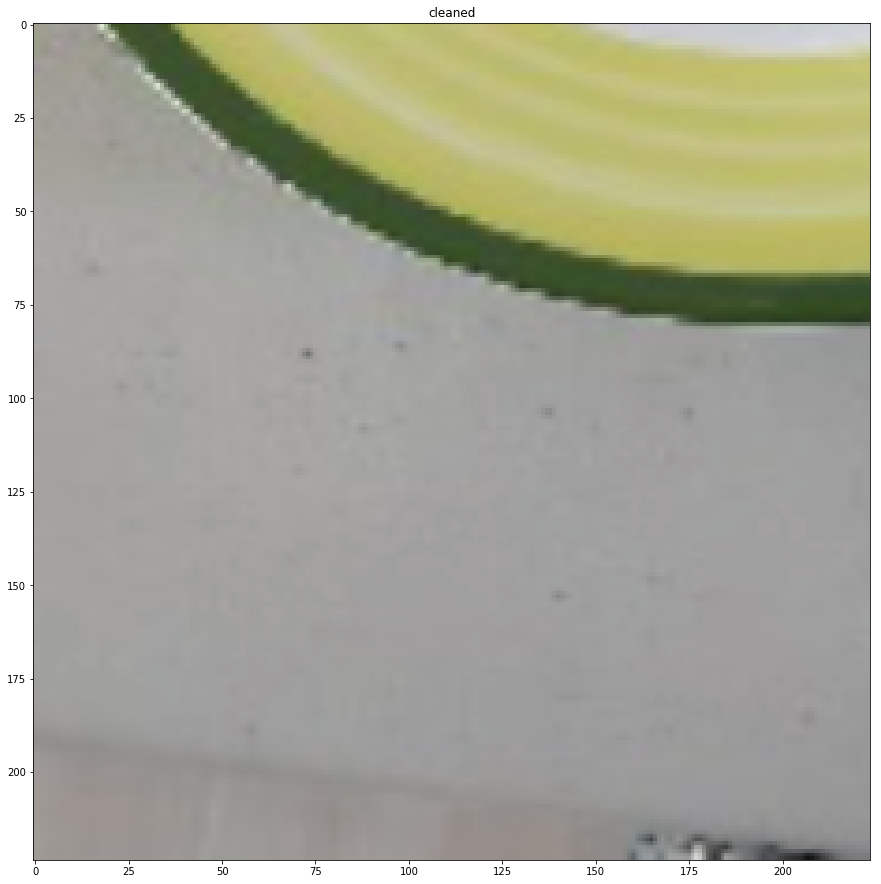

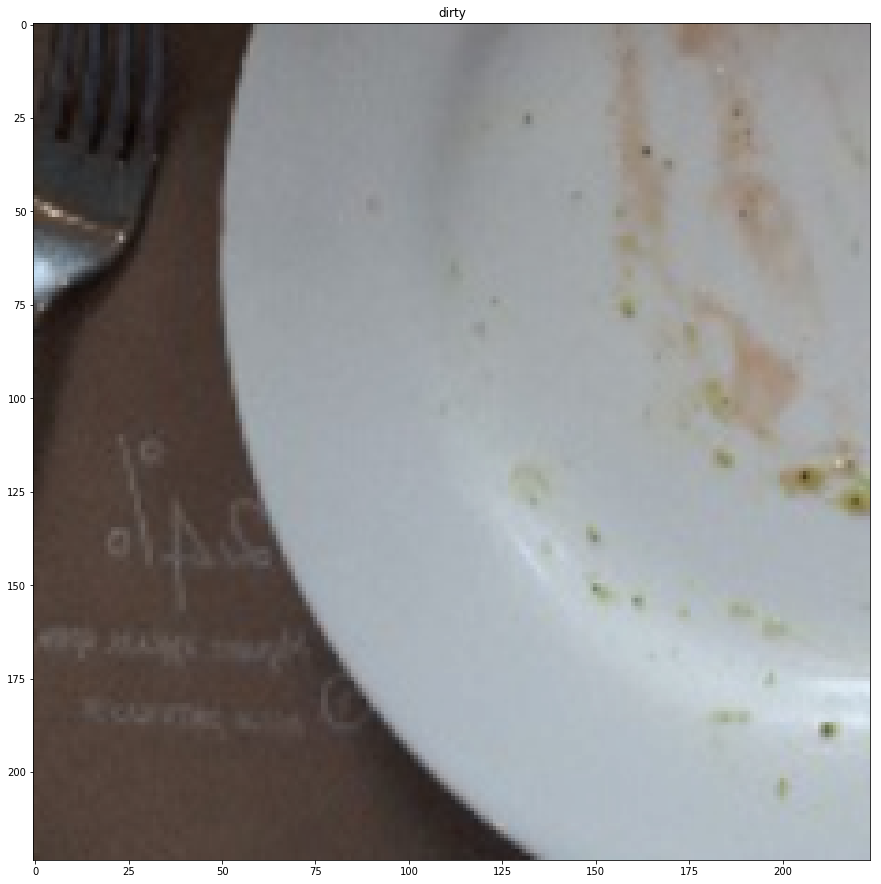

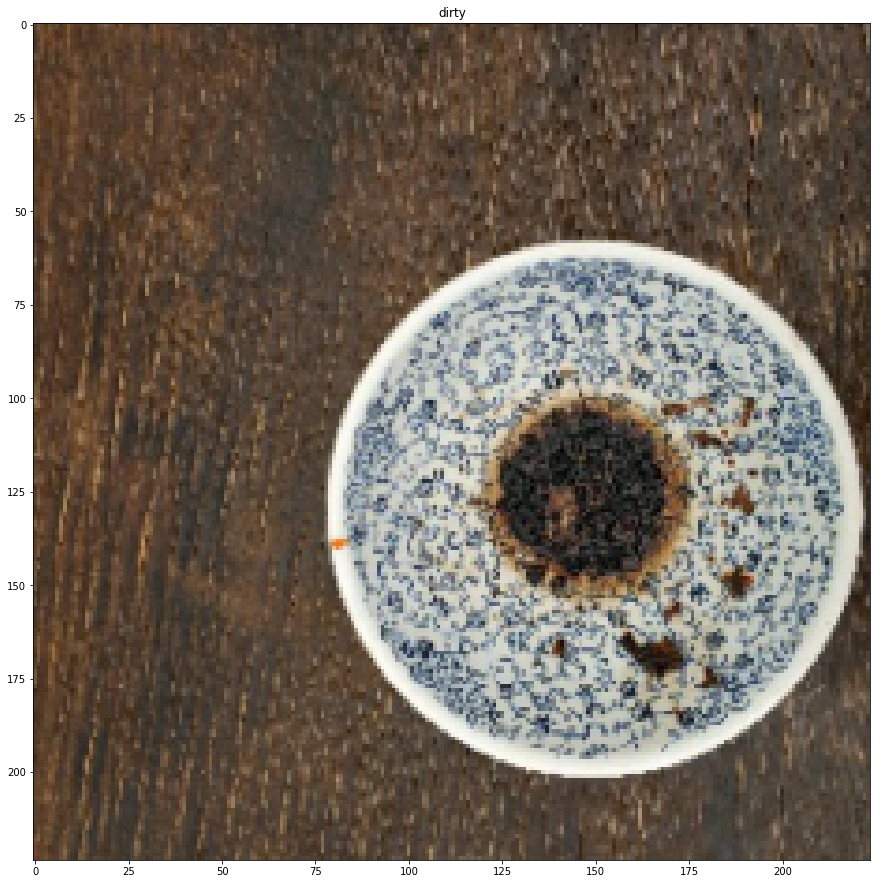

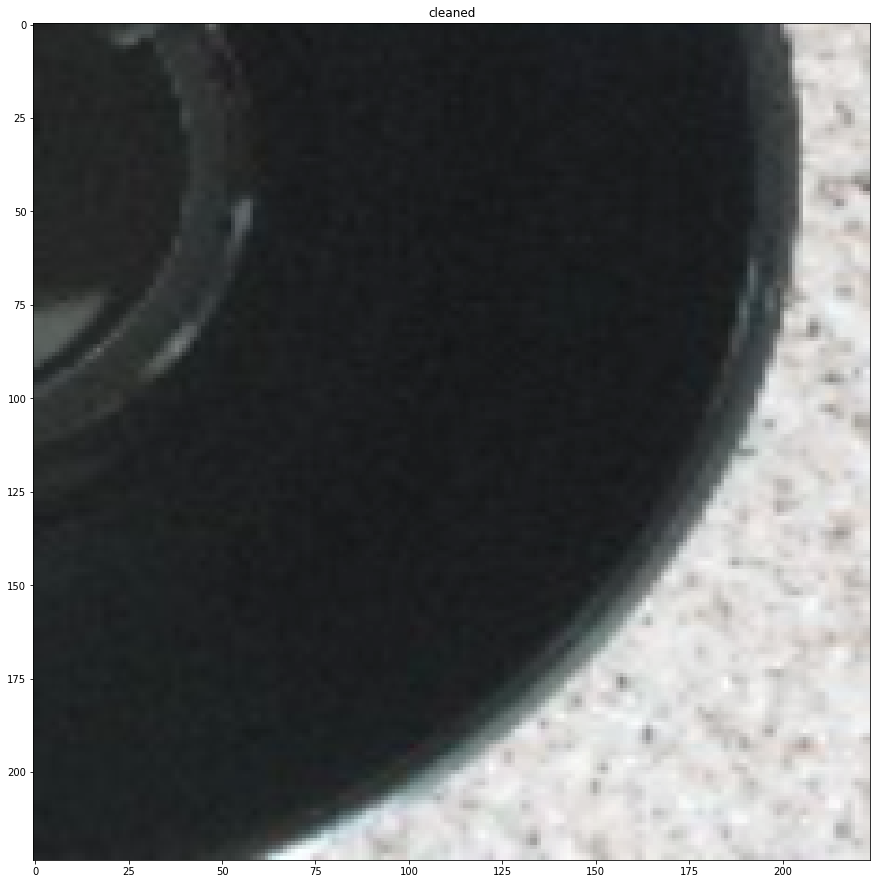

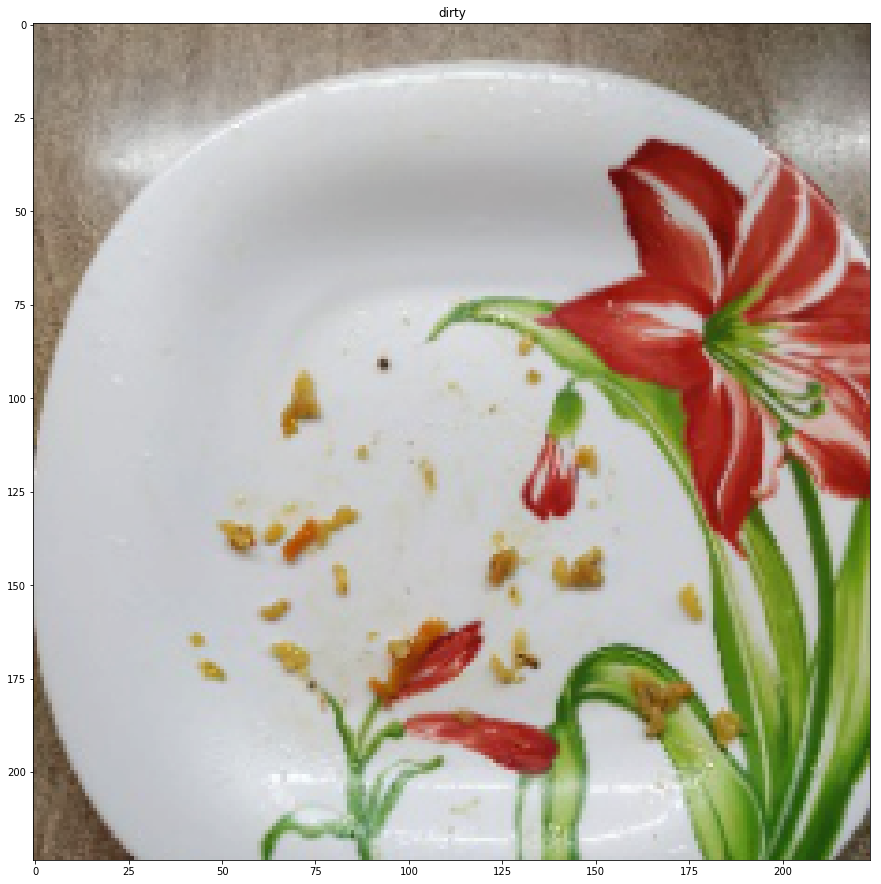

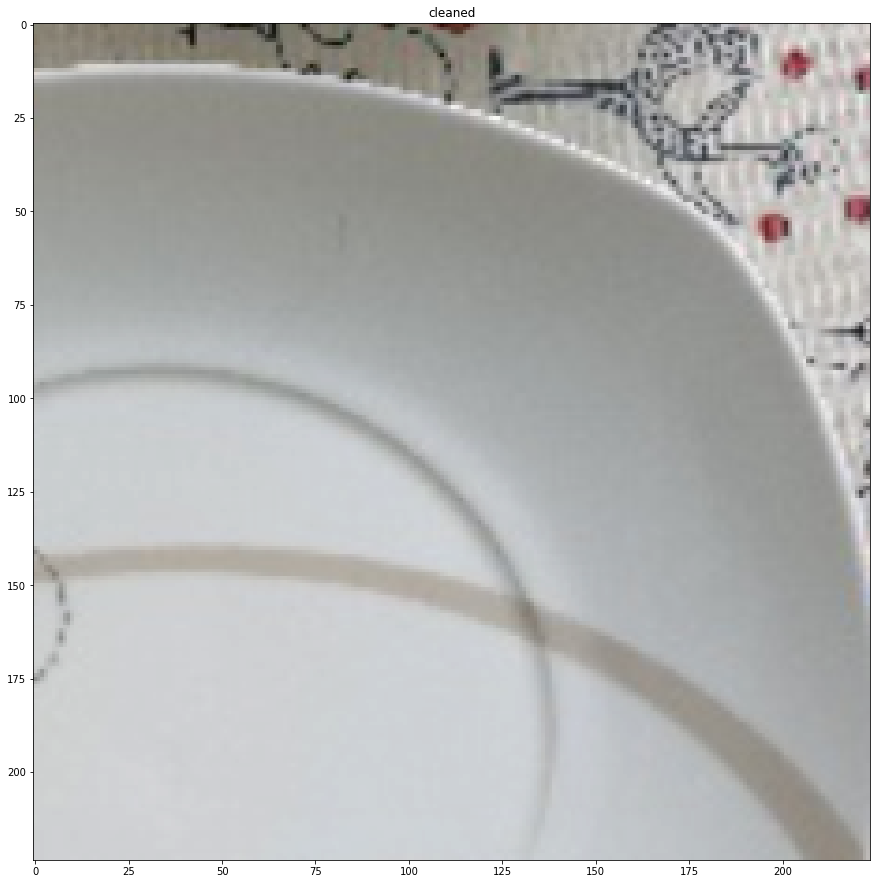

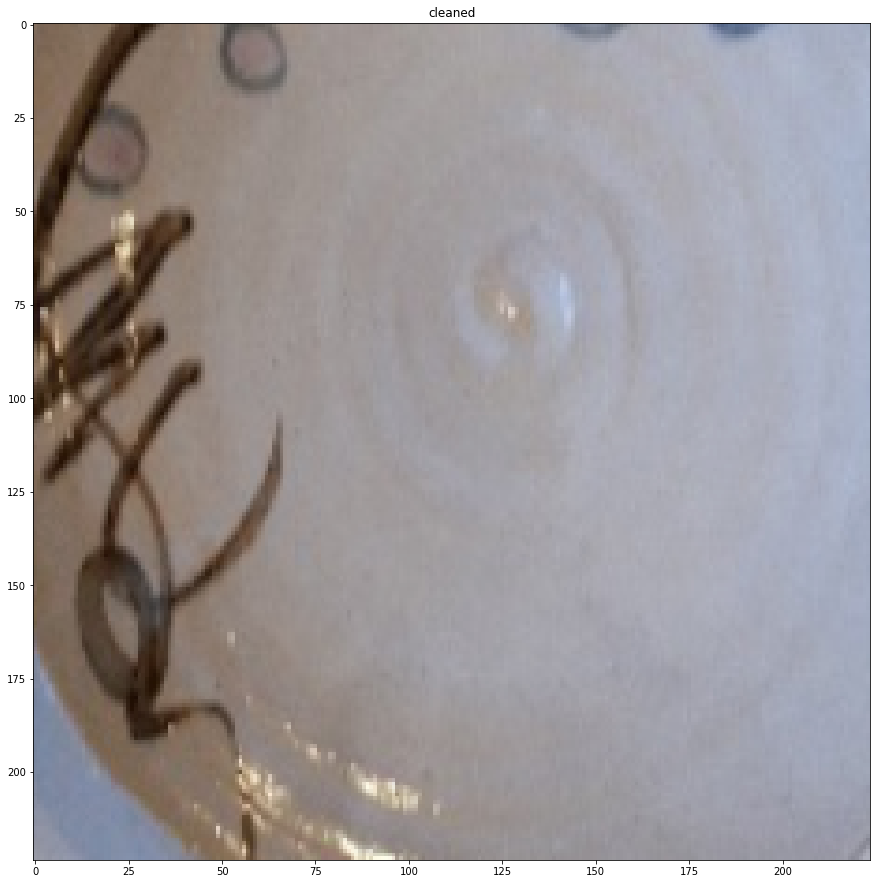

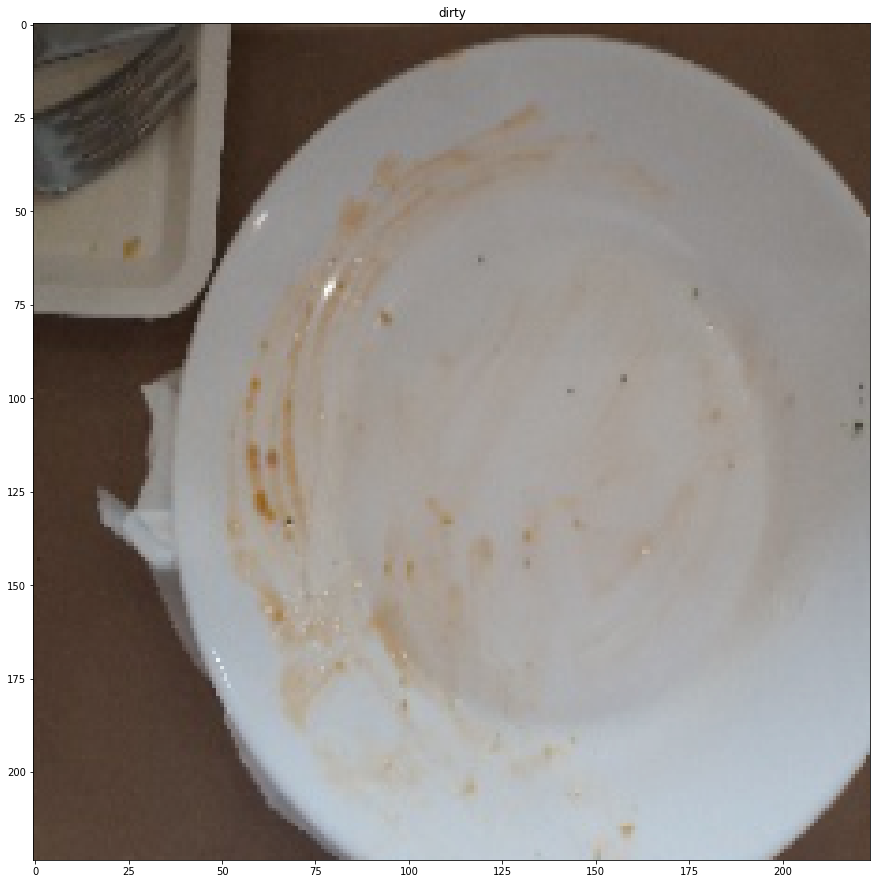

In [14]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [15]:

train_acc = []
train_loss = []
val_acc = []
val_loss = []
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
#                 scheduler.step()
                model.train()  # Set model to training mode
                acc_history=train_acc
                loss_history=train_loss
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode
                acc_history=val_acc
                loss_history=val_loss

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            loss_history.append(epoch_loss) 
            acc_history.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == 'val': scheduler.step(epoch_loss)
    return model

In [16]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
# optimizer=torch.optim.RMSprop(model.parameters(), lr=1.0e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.7)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s] 


In [17]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

train Loss: 0.9519 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.8304 Acc: 0.5000
Epoch 1/99:



100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

train Loss: 2.4701 Acc: 0.3125



100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 0.5743 Acc: 0.6250
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00,  8.97it/s]

train Loss: 0.4639 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 0.7192 Acc: 0.6250
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00,  8.89it/s]

train Loss: 0.4296 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.9541 Acc: 0.6250
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00,  8.54it/s]

train Loss: 0.4158 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 1.7070 Acc: 0.7500
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00,  8.46it/s]

train Loss: 0.6506 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 1.8816 Acc: 0.6250
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00,  8.67it/s]

train Loss: 1.3840 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.5425 Acc: 0.7500
Epoch 7/99:



100%|██████████| 4/4 [00:00<00:00,  9.01it/s]

train Loss: 0.7284 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.8014 Acc: 0.7500
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00,  8.94it/s]

train Loss: 0.5024 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 1.4980 Acc: 0.6250
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

train Loss: 0.4045 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 1.5348 Acc: 0.7500
Epoch 10/99:



100%|██████████| 4/4 [00:00<00:00,  8.53it/s]

train Loss: 1.0076 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0997 Acc: 0.6250
Epoch 11/99:



100%|██████████| 4/4 [00:00<00:00,  8.75it/s]

train Loss: 0.1093 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 1.7264 Acc: 0.7500
Epoch 12/99:



100%|██████████| 4/4 [00:00<00:00,  8.78it/s]

train Loss: 0.6090 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 1.3460 Acc: 0.7500
Epoch 13/99:



100%|██████████| 4/4 [00:00<00:00,  8.59it/s]

train Loss: 0.3991 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 1.5224 Acc: 0.7500
Epoch 14/99:



100%|██████████| 4/4 [00:00<00:00,  8.39it/s]

train Loss: 0.1083 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 1.4447 Acc: 0.7500
Epoch 15/99:



100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

train Loss: 0.3419 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.4030 Acc: 0.7500
Epoch 16/99:



100%|██████████| 4/4 [00:00<00:00,  8.34it/s]

train Loss: 0.0889 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 1.3108 Acc: 0.8750
Epoch 17/99:



100%|██████████| 4/4 [00:00<00:00,  8.73it/s]

train Loss: 0.1265 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 1.1626 Acc: 0.8750
Epoch 18/99:



100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

train Loss: 0.1356 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

val Loss: 1.1101 Acc: 0.8750
Epoch 19/99:



100%|██████████| 4/4 [00:00<00:00,  8.92it/s]

train Loss: 0.1283 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 1.1239 Acc: 0.6250
Epoch 20/99:



100%|██████████| 4/4 [00:00<00:00,  8.46it/s]

train Loss: 0.1911 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.0882 Acc: 0.8750
Epoch 21/99:



100%|██████████| 4/4 [00:00<00:00,  8.40it/s]

train Loss: 0.0534 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.1013 Acc: 0.8750
Epoch 22/99:



100%|██████████| 4/4 [00:00<00:00,  8.78it/s]

train Loss: 0.0606 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 1.0654 Acc: 0.8750
Epoch 23/99:



100%|██████████| 4/4 [00:00<00:00,  8.90it/s]

train Loss: 0.1126 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.0309 Acc: 0.8750
Epoch 24/99:



100%|██████████| 4/4 [00:00<00:00,  8.17it/s]

train Loss: 0.1407 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0788 Acc: 0.7500
Epoch 25/99:



100%|██████████| 4/4 [00:00<00:00,  8.47it/s]

train Loss: 0.2478 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0756 Acc: 0.7500
Epoch 26/99:



100%|██████████| 4/4 [00:00<00:00,  8.32it/s]

train Loss: 0.0305 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 1.0612 Acc: 0.7500
Epoch 27/99:



100%|██████████| 4/4 [00:00<00:00,  8.56it/s]

train Loss: 0.0099 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.0809 Acc: 0.8750
Epoch 28/99:



100%|██████████| 4/4 [00:00<00:00,  8.51it/s]

train Loss: 0.0695 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 1.0964 Acc: 0.8750
Epoch 29/99:



100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

train Loss: 0.1437 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.0842 Acc: 0.8750
Epoch 30/99:



100%|██████████| 4/4 [00:00<00:00,  8.43it/s]

train Loss: 0.1702 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0881 Acc: 0.8750
Epoch 31/99:



100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

train Loss: 0.1611 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 1.0795 Acc: 0.7500
Epoch 32/99:



100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

train Loss: 0.0827 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 1.1215 Acc: 0.8750
Epoch 33/99:



100%|██████████| 4/4 [00:00<00:00,  9.02it/s]

train Loss: 0.1056 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.1150 Acc: 0.8750
Epoch 34/99:



100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

train Loss: 0.0194 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

val Loss: 1.1165 Acc: 0.8750
Epoch 35/99:



100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

train Loss: 0.0214 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 1.1002 Acc: 0.7500
Epoch 36/99:



100%|██████████| 4/4 [00:00<00:00,  8.66it/s]

train Loss: 0.0331 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.1250 Acc: 0.7500
Epoch 37/99:



100%|██████████| 4/4 [00:00<00:00,  8.36it/s]

train Loss: 0.0281 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 1.1863 Acc: 0.8750
Epoch 38/99:



100%|██████████| 4/4 [00:00<00:00,  8.94it/s]

train Loss: 0.0628 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.1380 Acc: 0.8750
Epoch 39/99:



100%|██████████| 4/4 [00:00<00:00,  8.99it/s]

train Loss: 0.1821 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 1.1586 Acc: 0.8750
Epoch 40/99:



100%|██████████| 4/4 [00:00<00:00,  8.68it/s]

train Loss: 0.1566 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.1335 Acc: 0.8750
Epoch 41/99:



100%|██████████| 4/4 [00:00<00:00,  8.51it/s]

train Loss: 0.0349 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

val Loss: 1.1444 Acc: 0.6250
Epoch 42/99:



100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

train Loss: 0.0247 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 1.0969 Acc: 0.8750
Epoch 43/99:



100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

train Loss: 0.3081 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 1.0829 Acc: 0.8750
Epoch 44/99:



100%|██████████| 4/4 [00:00<00:00,  8.45it/s]

train Loss: 0.1092 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

val Loss: 1.0913 Acc: 0.8750
Epoch 45/99:



100%|██████████| 4/4 [00:00<00:00,  8.67it/s]

train Loss: 0.2233 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.0963 Acc: 0.8750
Epoch 46/99:



100%|██████████| 4/4 [00:00<00:00,  8.42it/s]

train Loss: 0.0835 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.0931 Acc: 0.8750
Epoch 47/99:



100%|██████████| 4/4 [00:00<00:00,  8.52it/s]

train Loss: 0.1397 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0778 Acc: 0.8750
Epoch 48/99:



100%|██████████| 4/4 [00:00<00:00,  8.80it/s]

train Loss: 0.1032 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

val Loss: 1.1346 Acc: 0.8750
Epoch 49/99:



100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

train Loss: 0.1690 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.0406 Acc: 0.8750
Epoch 50/99:



100%|██████████| 4/4 [00:00<00:00,  8.75it/s]

train Loss: 0.2103 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0625 Acc: 0.8750
Epoch 51/99:



100%|██████████| 4/4 [00:00<00:00,  8.36it/s]

train Loss: 0.0895 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 1.1069 Acc: 0.8750
Epoch 52/99:



100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

train Loss: 0.0668 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.1078 Acc: 0.7500
Epoch 53/99:



100%|██████████| 4/4 [00:00<00:00,  8.39it/s]

train Loss: 0.2660 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0746 Acc: 0.8750
Epoch 54/99:



100%|██████████| 4/4 [00:00<00:00,  8.59it/s]

train Loss: 0.0335 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0635 Acc: 0.8750
Epoch 55/99:



100%|██████████| 4/4 [00:00<00:00,  8.53it/s]

train Loss: 0.1565 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.0580 Acc: 0.8750
Epoch 56/99:



100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

train Loss: 0.0967 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0694 Acc: 0.8750
Epoch 57/99:



100%|██████████| 4/4 [00:00<00:00,  8.49it/s]

train Loss: 0.3112 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0956 Acc: 0.8750
Epoch 58/99:



100%|██████████| 4/4 [00:00<00:00,  8.51it/s]

train Loss: 0.3817 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0788 Acc: 0.8750
Epoch 59/99:



100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

train Loss: 0.0247 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.0094 Acc: 0.8750
Epoch 60/99:



100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

train Loss: 0.3539 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.0150 Acc: 0.8750
Epoch 61/99:



100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

train Loss: 0.0110 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 1.0188 Acc: 0.8750
Epoch 62/99:



100%|██████████| 4/4 [00:00<00:00,  8.50it/s]

train Loss: 0.0319 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 1.0682 Acc: 0.8750
Epoch 63/99:



100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

train Loss: 0.1483 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

val Loss: 1.0661 Acc: 0.8750
Epoch 64/99:



100%|██████████| 4/4 [00:00<00:00,  8.77it/s]

train Loss: 0.2418 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.1316 Acc: 0.8750
Epoch 65/99:



100%|██████████| 4/4 [00:00<00:00,  8.62it/s]

train Loss: 0.0368 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 1.0785 Acc: 0.8750
Epoch 66/99:



100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

train Loss: 0.1630 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.9957 Acc: 0.7500
Epoch 67/99:



100%|██████████| 4/4 [00:00<00:00,  8.59it/s]

train Loss: 0.3490 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 1.0101 Acc: 0.8750
Epoch 68/99:



100%|██████████| 4/4 [00:00<00:00,  8.32it/s]

train Loss: 0.2528 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 1.0014 Acc: 0.8750
Epoch 69/99:



100%|██████████| 4/4 [00:00<00:00,  8.75it/s]

train Loss: 0.0251 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

val Loss: 0.9895 Acc: 0.8750
Epoch 70/99:



100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

train Loss: 0.5012 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.0134 Acc: 0.8750
Epoch 71/99:



100%|██████████| 4/4 [00:00<00:00,  8.88it/s]

train Loss: 0.0723 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

val Loss: 1.0574 Acc: 0.8750
Epoch 72/99:



100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

train Loss: 0.1844 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 1.0560 Acc: 0.8750
Epoch 73/99:



100%|██████████| 4/4 [00:00<00:00,  8.46it/s]

train Loss: 0.0813 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0562 Acc: 0.8750
Epoch 74/99:



100%|██████████| 4/4 [00:00<00:00,  8.44it/s]

train Loss: 0.2306 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0133 Acc: 0.8750
Epoch 75/99:



100%|██████████| 4/4 [00:00<00:00,  8.68it/s]

train Loss: 0.3905 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 1.0760 Acc: 0.8750
Epoch 76/99:



100%|██████████| 4/4 [00:00<00:00,  8.66it/s]

train Loss: 0.3235 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.0911 Acc: 0.8750
Epoch 77/99:



100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

train Loss: 0.1319 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 1.0315 Acc: 0.8750
Epoch 78/99:



100%|██████████| 4/4 [00:00<00:00,  8.48it/s]

train Loss: 0.0218 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.9548 Acc: 0.8750
Epoch 79/99:



100%|██████████| 4/4 [00:00<00:00,  8.45it/s]

train Loss: 0.6982 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 0.9989 Acc: 0.8750
Epoch 80/99:



100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

train Loss: 0.0833 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 1.0217 Acc: 0.8750
Epoch 81/99:



100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

train Loss: 0.1905 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 1.0446 Acc: 0.8750
Epoch 82/99:



100%|██████████| 4/4 [00:00<00:00,  8.74it/s]

train Loss: 0.2868 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.1038 Acc: 0.8750
Epoch 83/99:



100%|██████████| 4/4 [00:00<00:00,  8.47it/s]

train Loss: 0.0119 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.1767 Acc: 0.7500
Epoch 84/99:



100%|██████████| 4/4 [00:00<00:00,  8.56it/s]

train Loss: 0.1639 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

val Loss: 1.1739 Acc: 0.7500
Epoch 85/99:



100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

train Loss: 0.0979 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 1.1768 Acc: 0.7500
Epoch 86/99:



100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

train Loss: 0.2875 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

val Loss: 1.1821 Acc: 0.6250
Epoch 87/99:



100%|██████████| 4/4 [00:00<00:00,  8.64it/s]

train Loss: 0.3617 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 1.1551 Acc: 0.7500
Epoch 88/99:



100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

train Loss: 0.1335 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 1.1396 Acc: 0.7500
Epoch 89/99:



100%|██████████| 4/4 [00:00<00:00,  8.52it/s]

train Loss: 0.1289 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

val Loss: 1.1138 Acc: 0.8750
Epoch 90/99:



100%|██████████| 4/4 [00:00<00:00,  8.41it/s]

train Loss: 0.2022 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 1.0972 Acc: 0.7500
Epoch 91/99:



100%|██████████| 4/4 [00:00<00:00,  8.78it/s]

train Loss: 0.0969 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

val Loss: 1.0954 Acc: 0.8750
Epoch 92/99:



100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

train Loss: 0.0551 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 1.0652 Acc: 0.8750
Epoch 93/99:



100%|██████████| 4/4 [00:00<00:00,  8.71it/s]

train Loss: 0.0375 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

val Loss: 1.0494 Acc: 0.8750
Epoch 94/99:



100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

train Loss: 0.1290 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.0878 Acc: 0.8750
Epoch 95/99:



100%|██████████| 4/4 [00:00<00:00,  8.36it/s]

train Loss: 0.1620 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

val Loss: 1.0369 Acc: 0.8750
Epoch 96/99:



100%|██████████| 4/4 [00:00<00:00,  8.96it/s]

train Loss: 0.0654 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 1.0044 Acc: 0.8750
Epoch 97/99:



100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

train Loss: 0.0166 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.0331 Acc: 0.8750
Epoch 98/99:



100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

train Loss: 0.6876 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 1.0548 Acc: 0.8750
Epoch 99/99:



100%|██████████| 4/4 [00:00<00:00,  8.52it/s]

train Loss: 0.1363 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

val Loss: 1.1111 Acc: 0.8750


Text(0.5, 0.98, 'RMSProp')

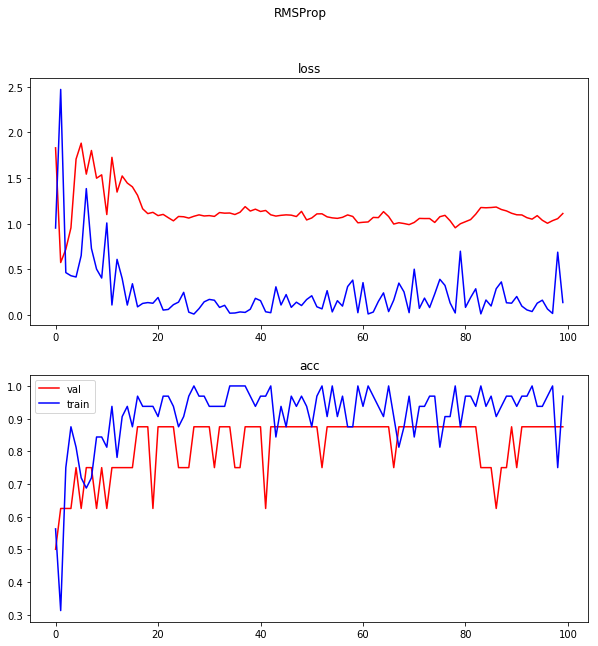

In [18]:
plt.figure(figsize=(10,10))
plt.title('dsadasdas')
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('RMSProp')

Text(0.5, 0.98, 'Adam')

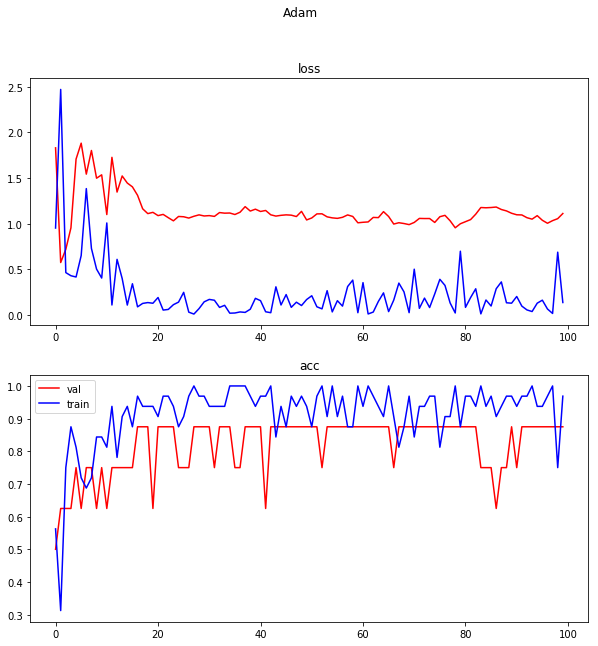

In [19]:
plt.figure(figsize=(10,10))
plt.title('dsadasdas')
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('Adam')

Text(0.5, 0.98, 'SGD')

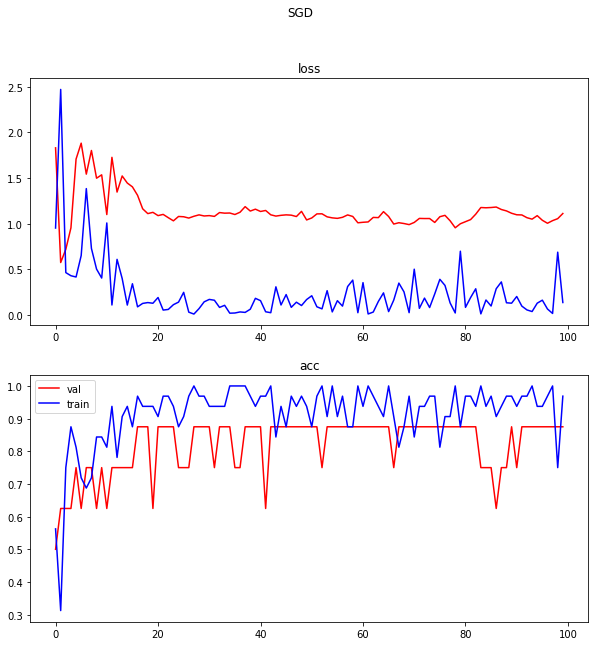

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('SGD')

Text(0.5, 0.98, 'SGD_0.9')

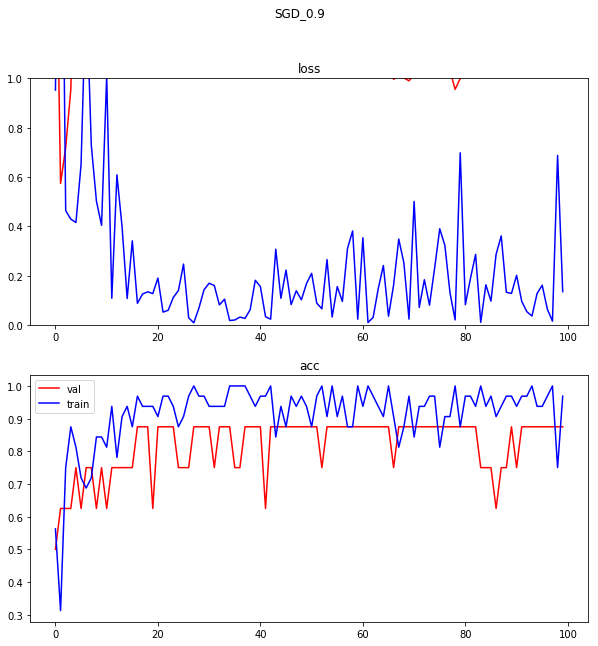

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(val_loss,'-r',train_loss, 'b')
plt.ylim(0, 1.0)
plt.title('loss')

plt.subplot(212)
plt.plot(val_acc,'-r',label='val')
plt.plot(train_acc, 'b',label='train')
plt.title('acc')
plt.legend()

plt.suptitle('SGD_0.9')

In [22]:
len(val_acc)

100

In [23]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [24]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [25]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 25.92it/s]


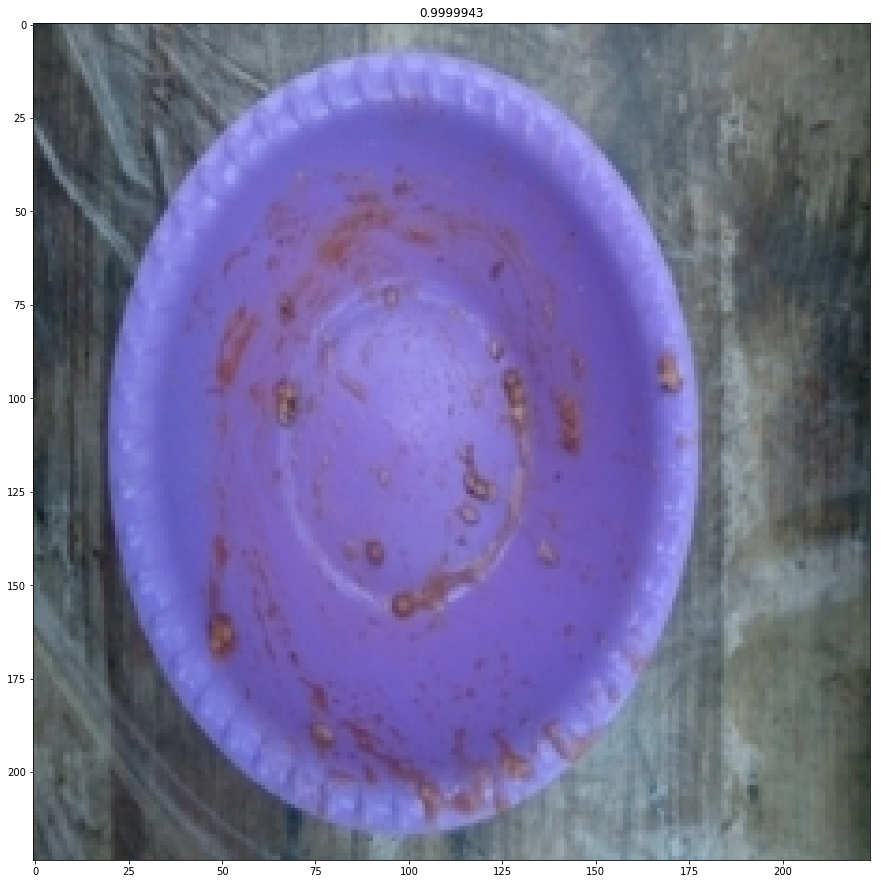

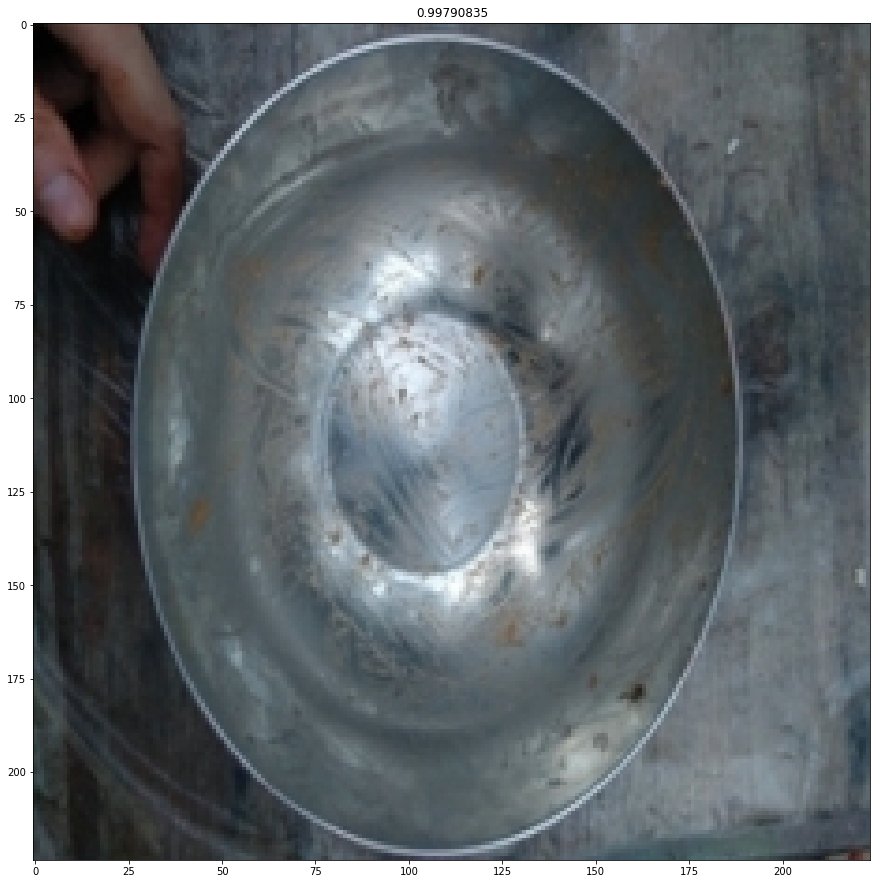

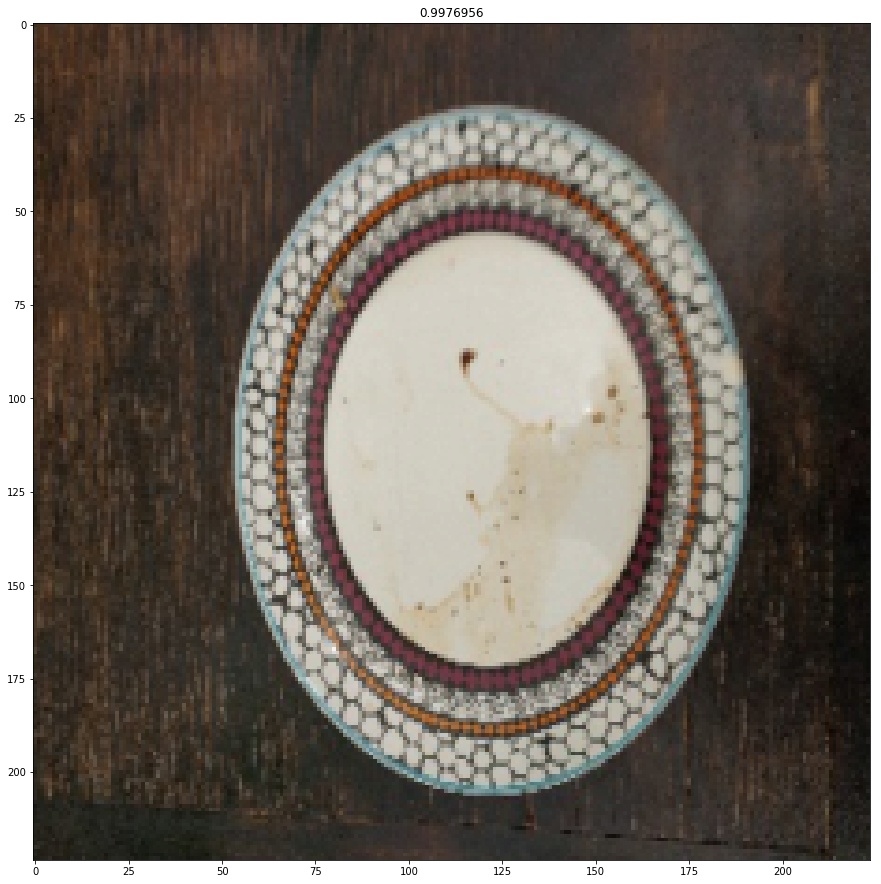

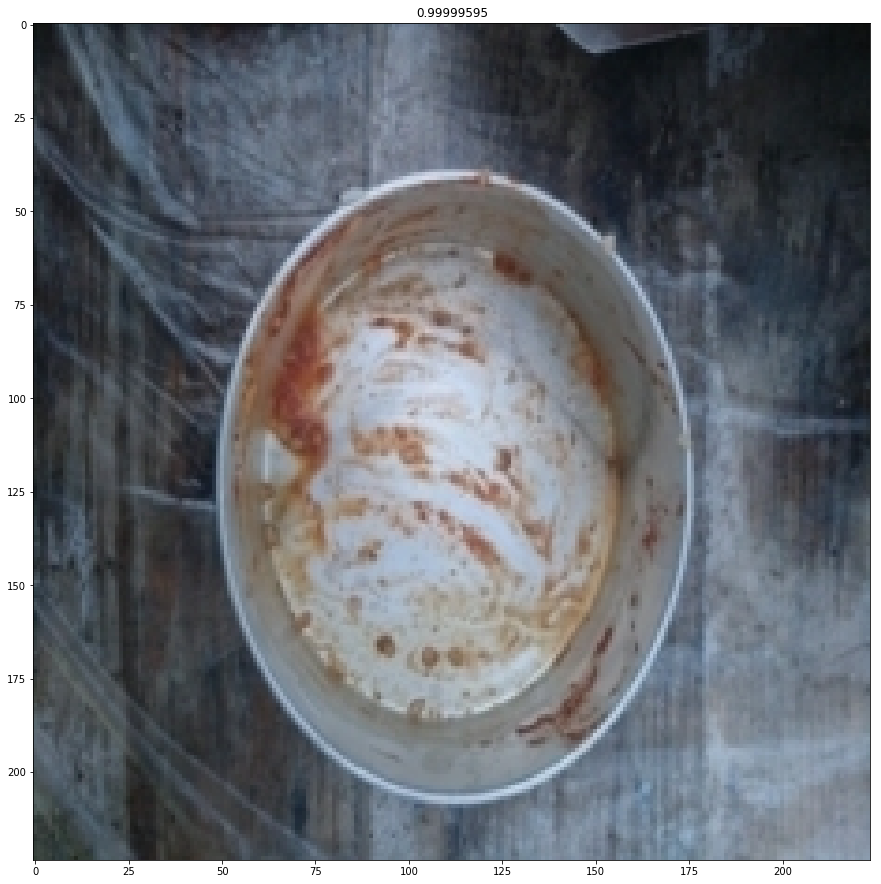

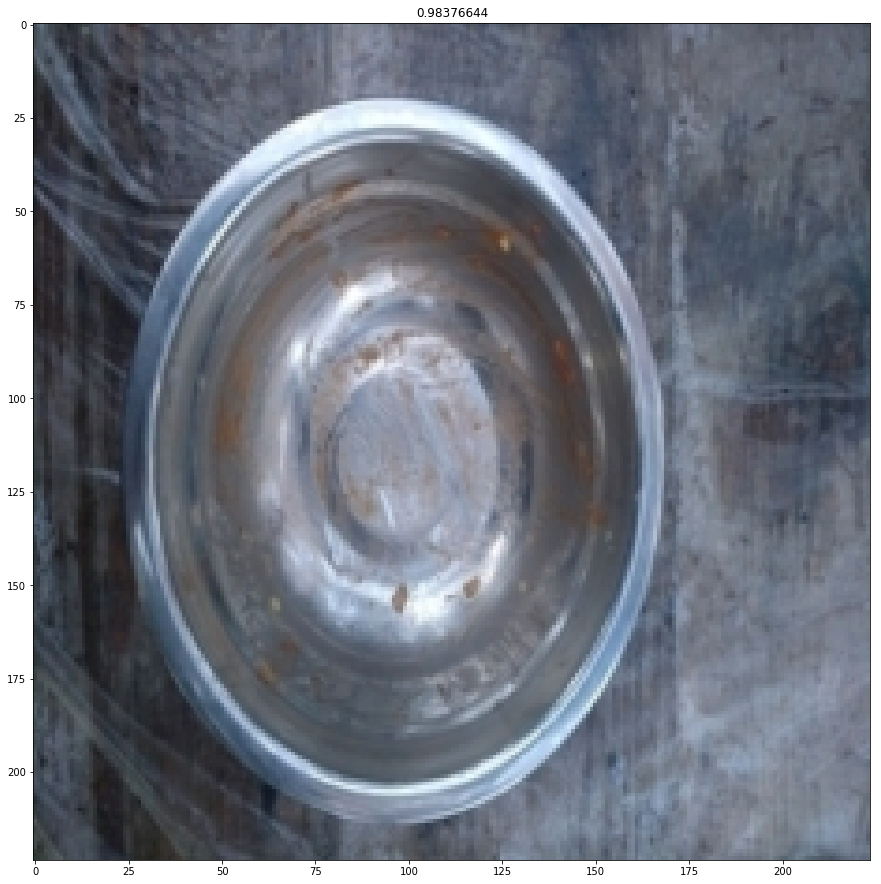

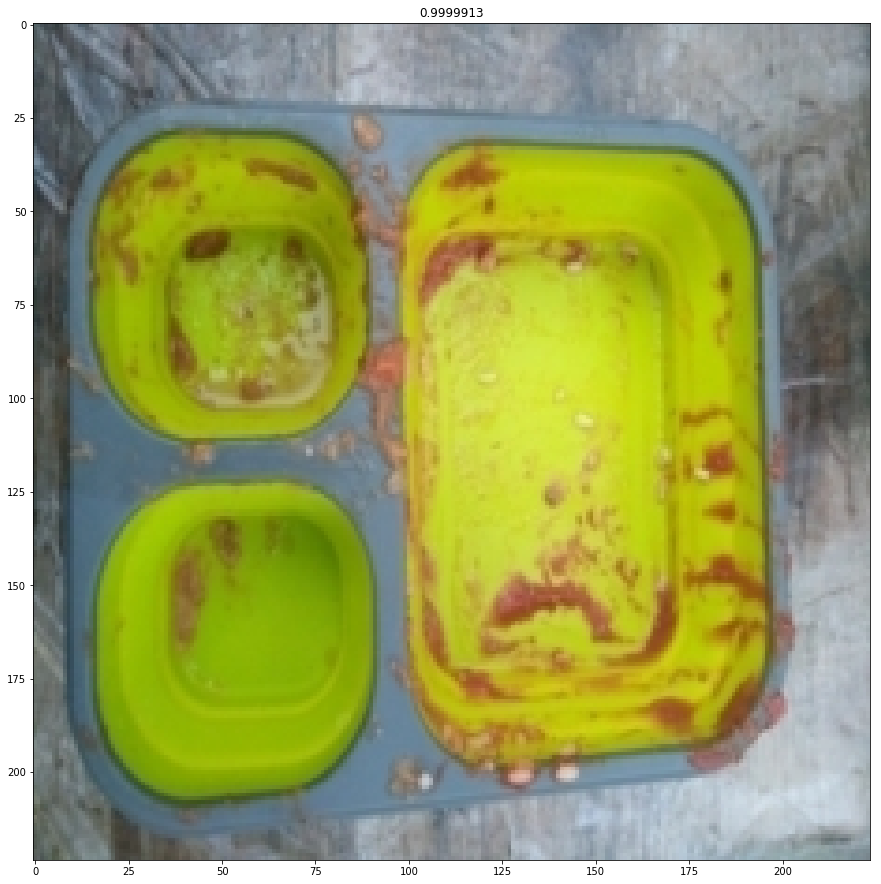

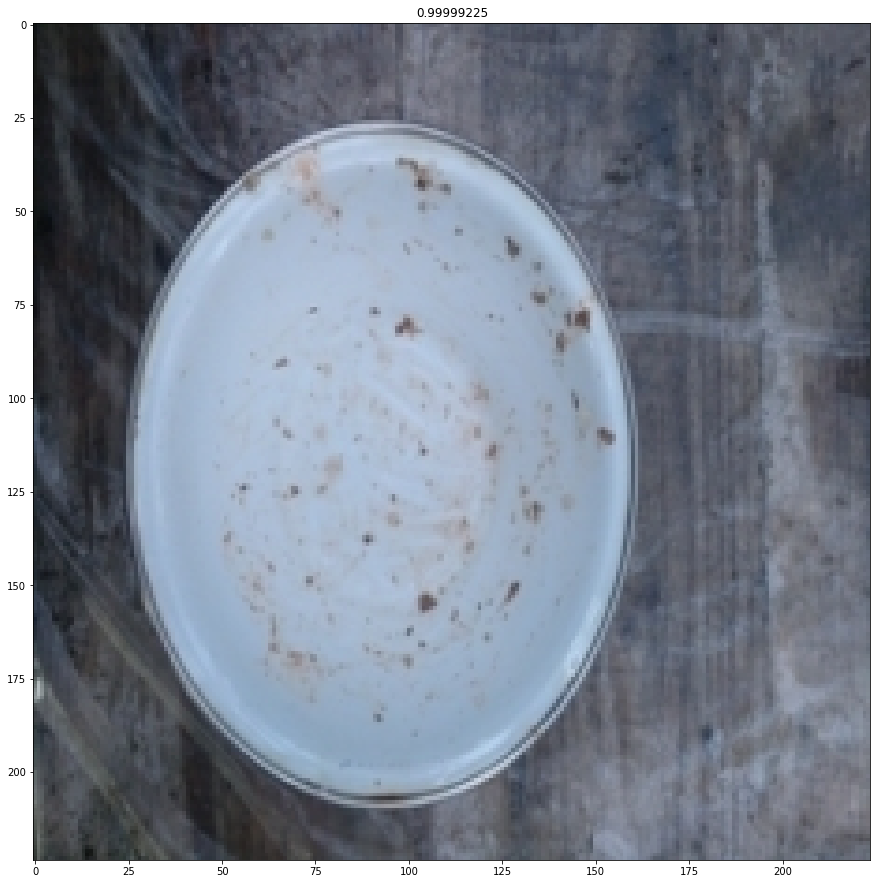

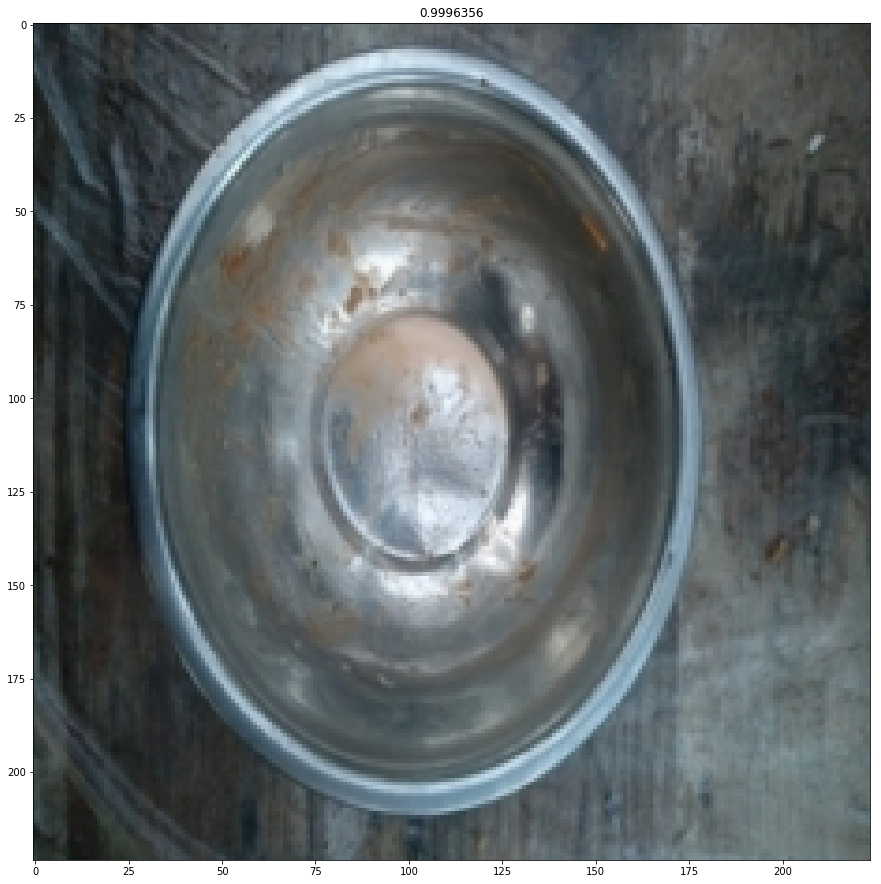

In [26]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [27]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [28]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [29]:
submission_df.to_csv('submission.csv')

In [30]:
print(os.listdir('../working/'))

['submission.csv', 'test', '__output__.json', '__notebook__.ipynb', 'val', 'train']


In [31]:
!rm -rf train val test